# README

In [5]:
README = '''
Julian Smoller ~ 4/7/2017

# Intro:
The purpose of this notebook is to parse the apparent number 
of pixels in an image that looks pixelated using Fourier analysis.

For example, an image might have 1000x1000 pixels but appears to 
have only 10x10 pixels, because there are colord blocks of sizde 100x100.
The code below will attempt to find the 10x10 dimensions.

'''
print(README)

%run commons.py
%matplotlib inline


Julian Smoller ~ 4/7/2017

# Intro:
The purpose of this notebook is to parse the apparent number 
of pixels in an image that looks pixelated using Fourier analysis.

For example, an image might have 1000x1000 pixels but appears to 
have only 10x10 pixels, because there are colord blocks of sizde 100x100.
The code below will attempt to find the 10x10 dimensions.




# Calculate color deltas

,delta_x,delta_y,value,x,y
0,0.0,0.0,"(0, 0, 0)",0,0
1,255.0,0.0,"(0, 0, 0)",0,1
2,255.0,0.0,"(0, 0, 0)",0,2
3,255.0,0.0,"(0, 0, 0)",0,3
4,255.0,0.0,"(0, 0, 0)",0,4


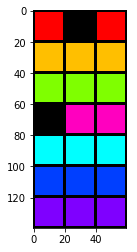

In [6]:
def get_pixel_deltas(im,x_max=100,y_max=100):
    '''For every x,y coordinate in an image, calculate delta_x and delta_y,
    which are defined as the Euclidean distance to the color of the next pixel 
    in the x or y direction. Returns a dataframe with x*y rows and columns x, y,
    delta_x, and delta_y.'''
    x_max = min(x_max,im.size[0]-1)
    y_max = min(y_max,im.size[1]-1)
    if x_max*y_max>666666: # emergency cutoff
        print('Oops! Image is too large.')
        return
    pixels = {'x':[],'y':[],'value':[],'delta_x':[],'delta_y':[]}
    for x in range(x_max):
        for y in range(y_max):
            value = im.getpixel((x,y))
            delta_x = scipy.spatial.distance.euclidean(value,im.getpixel((x+1,y)))
            delta_y = scipy.spatial.distance.euclidean(value,im.getpixel((x,y+1)))
            pixels['x'].append(x)
            pixels['y'].append(y)
            pixels['value'].append(value)
            pixels['delta_x'].append(delta_x)
            pixels['delta_y'].append(delta_y)
    pixels = pd.DataFrame(pixels)
    return pixels

# Create an artificial image with obviously sized blocks
df = pd.DataFrame({'a':[0,1,2,None,4,5,6],'b':[None,1,2,3,4,5,6],'c':[0,1,2,3,4,5,6]})
im = draw_df(df,scale=20)
show(im)
# Calculate + scale pixel deltas within a region
pixels = get_pixel_deltas(im)
pixels.head()

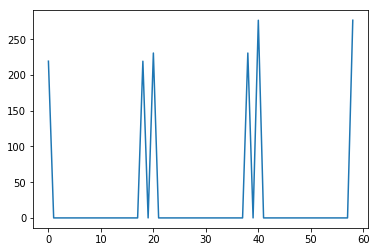

In [7]:
# Aggregate delta_x per x ; the largest deltas should occur when x%block_width==0 
deltas = pixels.groupby('x')['delta_x'].mean() 
plt.plot(deltas)

# Apply Fourier Transform

19.6666666667


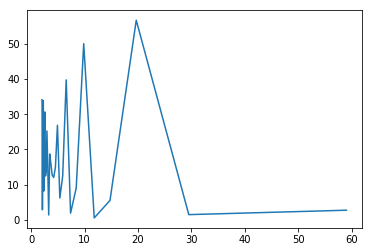

In [9]:
def find_freqs(y,blackman=False):
    '''Apply Fast Fourier Transform (FFT) to data points Y;
    return a dataframe of frequencies and relative values,
    with "strongest" frequency having greatest relative value'''
    y = y/y.mean() if y.mean()!=0 else y # Scale values
    N = len(y)
    if blackman: # Apply Blackman window
        w = scipy.signal.blackman(N)
        y = y*w
    coefs = np.fft.fft(y)
    freqs = np.fft.fftfreq(N)
    freqs = pd.DataFrame({'coef':coefs,'freq':freqs})
    freqs = freqs[freqs['freq']>0].copy()
    freqs['abs_coef'] = freqs['coef'].map(lambda x: np.abs(x))
    freqs['period'] = freqs['freq'].map(lambda x: 1.0/x if x>0 else 0)
    return freqs

def pick_best_period(freqs):
    '''Given a dataframe of frequencies, just return the 
    period corresponding to the frequency with the largest value'''
    return freqs.ix[freqs['abs_coef'].idxmax(),'period']

# Apply FTT to calculate frequences
freqs = find_freqs(deltas,blackman=False)
print(pick_best_period(freqs))
plt.plot(freqs['period'],freqs['abs_coef'])

# Parse block size in image

(19.666666666666664, 20.0)

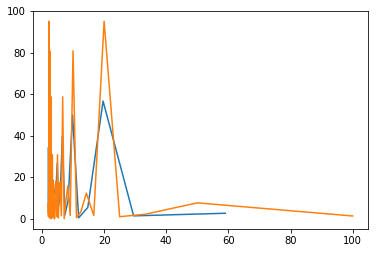

In [10]:
def find_block_size(im,x_max=100,y_max=100,blackman=False,plot=True):
    '''Given an image, calculate the "best" block size (n pixels per block);
    uses a Fourier transform to find "strongest" frequency in color deltas;
    returns period_x and period_y, corresponding to w and h for block size
    '''
    pixels = get_pixel_deltas(im,x_max=x_max,y_max=y_max)
    deltas_x = pixels.groupby('x')['delta_x'].mean()
    deltas_y = pixels.groupby('y')['delta_y'].mean()
    freqs_x = find_freqs(deltas_x,blackman=False)
    freqs_y = find_freqs(deltas_y,blackman=False)
    if plot:
        plt.plot(freqs_x['period'],freqs_x['abs_coef'])
        plt.plot(freqs_y['period'],freqs_y['abs_coef'])
    period_x = pick_best_period(freqs_x)
    period_y = pick_best_period(freqs_y)
    return (period_x,period_y)

# Test function on artifical image: just a dataframe with colored cells
df = pd.DataFrame({'a':[0,1,2,None,4,5,6],'b':[None,1,2,3,4,5,6],'c':[0,1,2,3,4,5,6]})
im = draw_df(df,scale=20)
find_block_size(im)

# Example: watermelon

Total pixels: 96 96
N blocks (counted, manually): 15 15
Pixels per block (estimated): 6.4 6.4
Pixels per block (calculated): 6.33333333333 6.33333333333
N blocks (calculated): 15.1578947368 15.1578947368


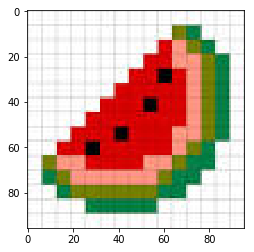

In [12]:
path_in = 'data/input/watermelon_small.jpeg'
im = Image.open(path_in)
show(im)
# How many blocks are there? Count them!
nx = 15 # manual count
ny = 15 # manual count
print('Total pixels:',im.size[0],im.size[1])
print('N blocks (counted, manually):',nx,ny)
print('Pixels per block (estimated):',im.size[0]/nx,im.size[1]/ny)
# How many blocks are there? Parse them!
w,h = find_block_size(im,x_max=200,y_max=200,plot=False)
print('Pixels per block (calculated):',w,h)
n_blocks_x = im.size[0]/w
n_blocks_y = im.size[1]/h
n_blocks = n_blocks_x*n_blocks_y
print('N blocks (calculated):',n_blocks_x,n_blocks_y)

# Example: Pikachu

Total pixels: 736 682
N blocks (counted, manually): 41 38
Pixels per block (estimated): 17.951219512195124 17.94736842105263
Pixels per block (calculated): 18.1818181818 18.1818181818
N blocks (calculated): 40.48 37.51


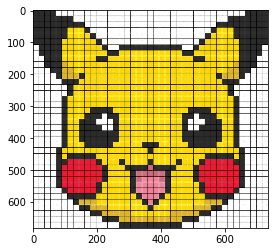

In [13]:
path_in = 'data/input/pikachu.jpg'
im = Image.open(path_in)
show(im)
# How many blocks are there? Count them!
nx = 41 # manual count
ny = 38 # manual count
print('Total pixels:',im.size[0],im.size[1])
print('N blocks (counted, manually):',nx,ny)
print('Pixels per block (estimated):',im.size[0]/nx,im.size[1]/ny)
# How many blocks are there? Parse them!
w,h = find_block_size(im,x_max=200,y_max=200,plot=False)
print('Pixels per block (calculated):',w,h)
n_blocks_x = im.size[0]/w
n_blocks_y = im.size[1]/h
n_blocks = n_blocks_x*n_blocks_y
print('N blocks (calculated):',n_blocks_x,n_blocks_y)

# View pixel deltas

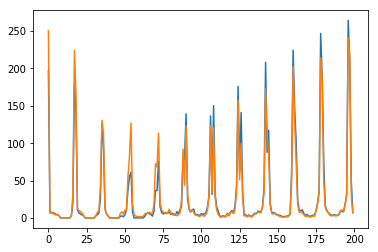

In [14]:
# In this image, the mean pixel delta is highest for specific values of x and y
pixels = get_pixel_deltas(im,x_max=200,y_max=200)
deltas_x = pixels.groupby('x')['delta_x'].mean()
deltas_y = pixels.groupby('y')['delta_y'].mean()
plt.plot(deltas_x)
plt.plot(deltas_y)